# Notebook to reproduce fig. 3 of the DEXP manuscript

In [1]:
# clone github
#!pip install git+https://github.com/BenjMy/dEXP_imaging

In [2]:
# clone github
!pip install git+https://github.com/BenjMy/dEXP_imaging
import numpy as np
import matplotlib.pyplot as plt

  Cloning https://github.com/BenjMy/dEXP_imaging to /tmp/pip-req-build-kyww7enu
  Running command git clone -q https://github.com/BenjMy/dEXP_imaging /tmp/pip-req-build-kyww7enu
  Resolved https://github.com/BenjMy/dEXP_imaging to commit c6b9865890e53680a9fbca5aa6cefa5bff8c43da


In [3]:
# Tweak the figure style
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['font.size'] = 15
# Tweak the figure style
plt.rcParams.update({
    'ytick.labelsize': 'small',
    'xtick.labelsize': 'small',
    'axes.labelsize': 'small',
    'axes.titlesize': 'medium',
    'grid.color': '0.75',
    'grid.linestyle': ':',
})
import os
os.chdir('../')

In [9]:
import os
import pickle

from fatiando.vis import mpl #, myv
from fatiando import gridder, mesher, utils
from fatiando.gravmag import prism, imaging, transform
from fatiando.vis.mpl import square

# my own functions
import lib.dEXP as dEXP
from lib.dEXP import _fit
import lib.plot_dEXP as pEXP
import lib.utils_dEXP as uEXP

import notebooks_GRL.load_MALM_model as MALMmod
import notebooks_GRL.load_MALM_real as MALMreal
import lib.set_parameters as para

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

# icsd functions
from importers.read import load_obs, load_geom

ModuleNotFoundError: No module named 'lib.tools'

In [13]:
os.getcwd()

'/home/ben/Documents/GitHub/BenjMy/dEXP_imaging'

load./notebooks_GRL/data/phNO/NoAno_uz0_grid.dat
90000
90000
90000


NameError: name 'para' is not defined

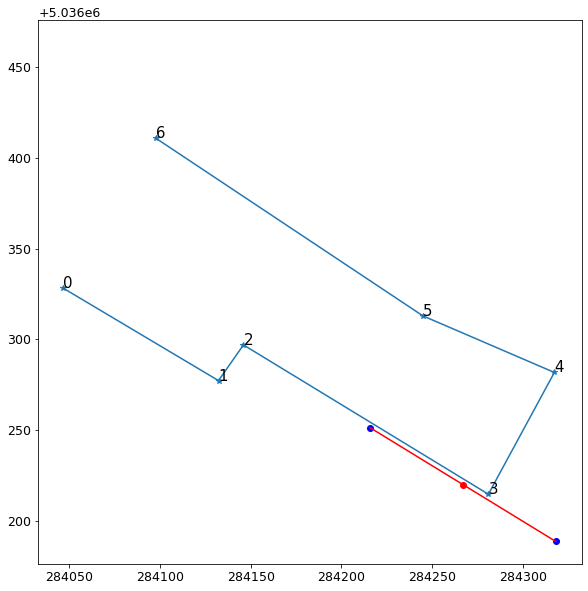

In [14]:
#%% ------------------------------- MALM DATA synthetic

interp_size = 300
smooth = 'CubicSmoothingSpline' #'Hanning+Lowpass'
# smooth = 'CubicSmoothingSpline + interp1d' #'Hanning+Lowpass'
interp = False
file = 'NoAno'


path =  './notebooks_GRL/data/phNO/'
dataset = MALMmod.load_MALM_Landfill_model(path=path, 
                                    filename=file,
                                    shape = (300,300),
                                    field=True,
                                    interp = interp,
                                    radius=60)


coord_xyz, coord_xyz_int = dataset[0:2]
coord_xyz_int
Uload = dataset[2]
coords_liner = dataset[3]
shape, max_elevation = dataset[4:6]

dict_data = dataset[7]
dict_data['AnoBool']

xA = (dict_data['HZ'][0][0]+dict_data['HZ'][0][1])/2
x1 = dict_data['HZ'][0][2]
y1 = dict_data['HZ'][0][0]
y2 = dict_data['HZ'][0][1]

z1 = dict_data['HZ'][1]
z2 = z1 - dict_data['HZ'][2]

p = dataset[6]         # line points                                       
# set imaging pseudo-inversion parameters                                                                        
parameters = para.set_par(shape=shape,max_elevation=max_elevation)

scaled = parameters[0]
SI = parameters[1]
zp, qorder, nlay = parameters[2:5]
minAlt_ridge, maxAlt_ridge = parameters[5:7]

max_elevation = 30
# nlay = 50

# xp, yp, zp = coord_xyz_int
xp, yp, zp = coord_xyz
# len(xp)
Uini = Uload[0] # U_raw, Ucor, U_int, Ucor_int
p1 , p2 = p

rot = 60
origin=(max(xp), min(yp))
point_torotate = np.array([xp, yp])
xp_r, yp_r = MALMreal.rotate_60(origin, point_torotate, angle_deg=rot, showfig=False)
Xs = xp_r-min(xp_r)
Ys = yp_r-min(yp_r) 
    
prl = 60
# shape = shape  (max(xp)-min(xp))/
shape = (150,150)
xint_scipy, yint_scipy = gridder.regular((min(Xs)-prl, max(Xs)+prl, 
                          min(Ys)-prl, max(Ys)+prl),shape=shape)

In [ ]:
#%% ------------------------------- MALM DATA real
MainPath= r'E:\Padova\Software\SourceInversion\Potential_field_imaging\dEXP_imaging\examples_in_prep\\'
# os.chdir(MainPath)
## --------- read MALM measured data file (with electrode positions) --------- ##
# RealData = np.loadtxt("./1_Data_2_plot/to_plot.dat",skiprows=0,delimiter='\t') 
out = MALMreal.load_MALM_Porto_real(MainPath + '/malm_models/',
                          MainPath + './malm_models/XYObs_real_f_m3.txt',
                          shape=(100,100),
                          radius=200,
                          rcor=10,
                          rot=0,
                          showfig=False)

# coords_liner = out[3]
p = out[6]         # line points  
p1f , p2f = p
coord_xyz, coord_xyz_int = out[0:2]
xf, yf, zf = coord_xyz
# len(xp)

out_r = MALMreal.load_MALM_Porto_real(MainPath + '/malm_models/',
                          MainPath + './malm_models/XYObs_real_f_m3.txt',
                          shape=(100,100),
                          radius=200,
                          rcor=10,
                          rot=60,
                          showfig=False)

# coords_liner = out[3]
p = out_r[6]         # line points  
p1f_r , p2f_r = p
coord_xyz_r, coord_xyz_int_r = out_r[0:2]
Uload_r = out_r[2]
uf = Uload_r[1] # U_raw, Ucor, U_int, Ucor_int
# xf_rtmp, yf_rtmp, zf_rtmp = coord_xyz

# plt.figure()
# plt.scatter(xf_rtmp, yf_rtmp, c=uf, cmap='viridis',vmax=0.05)
# plt.colorbar()
# plt.axis('square')
# plt.show()

In [15]:
# find point position with respect to line equation defined by p1 and p2
U_af, p_af, bool_abovef, U_bf, p_bf = MALMmod.isabove(xf, yf, uf, 
                                  np.array(p1),np.array(p2))
# Compute p1 and p2 line equation ax + by + c = 0
af, bf, cf = MALMmod.slope(p1,p2)

# Mirror points with respect to p1p2 line
Umirrorf, xy_mirrorf = MALMmod.mirrorU_alongLine(U_af,p_af,bool_abovef,af,bf,cf)

U_a_intf = gridder.interp_at(xy_mirrorf[:,0], xy_mirrorf[:,1], Umirrorf, xf, yf, algorithm='cubic', 
                        extrapolate=True)   
# U_mirror_int = np.copy(U_a_int)
U_mirror_intf = np.copy(uf)
U_mirror_intf[np.where(bool_abovef == True)[0]]= U_a_intf[np.where(bool_abovef == True)[0]]

xf_mirror = np.hstack([xy_mirrorf[:,0],p_af[:,0]])
yf_mirror = np.hstack([xy_mirrorf[:,1],p_af[:,1]])
uf_mirror = np.hstack([Umirrorf,U_af])


NameError: name 'xf' is not defined

In [ ]:
#%% choose raw or mirrored field
Uf = np.copy(uf)
# Uf  = np.copy(uf_mirror)
# xf = xf_mirror
# yf = yf_mirror

In [ ]:
# %% rotate and rescale all

rot = 60
origin=(max(xp), min(yp))
# origin=(max(Xf), min(Yf))
point_torotate = np.array([xp, yp])
xp_r, yp_r = MALMreal.rotate_60(origin, point_torotate, angle_deg=rot, showfig=False)

point_torotate = np.array([xf, yf])
xf_r, yf_r = MALMreal.rotate_60(origin, point_torotate, angle_deg=rot, showfig=False)
Xfs = xf_r-min(xp_r)
Yfs = yf_r-min(yp_r)

plt.figure()
plt.scatter(xf_r, yf_r, c=Uf, cmap='viridis',vmax=0.0175)
plt.colorbar()
plt.axis('square')
plt.show()

# print(Uf[0:2])

point_torotate = np.array([[dict_data['HZ'][0][0],dict_data['HZ'][0][1]],
                          [dict_data['HZ'][0][2],dict_data['HZ'][0][2]]])
xA_r, yA_r =  MALMreal.rotate_60(origin,point_torotate,angle_deg=rot, showfig=False) #58.511
xA_r = xA_r-min(xp_r)
yA_r = yA_r-min(yp_r)
    
point_torotate = np.array(coords_liner).T
coords_linerx, coords_linery =  MALMreal.rotate_60(origin,point_torotate,angle_deg=rot, showfig=False)
coords_linerx = coords_linerx-min(xp_r)
coords_linery = coords_linery-min(yp_r)
coords_liner_s = np.array([coords_linerx, coords_linery]).T
    

plt.figure()
plt.scatter(Xfs, Yfs, c=Uf, cmap='viridis',vmax=0.05)
plt.colorbar()
plt.axis('square')
plt.show()
    

In [ ]:
#%% Solution 1
# extrapolate False and fill with 0 before derivative - mask them later on 
U_int_scipyf = gridder.interp_at(Xfs,Yfs,Uf, xint_scipy, yint_scipy, algorithm='cubic', extrapolate=False)
InterpData = np.array([xint_scipy, yint_scipy, U_int_scipyf]).T
where_are_NaNs = np.isnan(InterpData)
InterpData[where_are_NaNs] = 0.0074
xint_scipy, yint_scipy, U_int_scipyf = InterpData.T


In [ ]:
XFs, YFs = xint_scipy,yint_scipy
UF = U_int_scipyf
UF = dEXP.smooth2d(XFs, YFs, UF, sigma=2)
# plt.savefig('smooth2d' + str(file) + '.png', dpi=450)
UFs = UF

In [ ]:

plt.figure()
plt.scatter(XFs, YFs, c=UF, cmap='viridis')
plt.colorbar()
plt.axis('square')
plt.show()


offset = 255 #260
p1_s = np.array([p1f_r[0] -min(xp_r)+offset,p2f_r[0] -min(xp_r)+offset])
p2_s = np.array([p1f_r[1] -min(yp_r),p2f_r[1] -min(yp_r) ])
ax, plt = pEXP.plot_field(XFs,YFs,UF, shape,
            Vminmax=[0,0.02])
ax.plot(coords_liner_s[2:5,0],coords_liner_s[2:5,1],'k')
ax.set_xlim([300,500])
ax.set_ylim([300,500])
ax.plot(p1_s,p2_s,'r')

x_axis = 'x'
# xx, yy, distance, profile, ax, plt = pEXP.plot_line(Xs, Ys, U ,p1_s,p2_s, 
#                                                     interp=True, smooth=True, 
#                                                     xaxis = x_axis)
p1_s = np.array([p1f_r[0] -min(xp_r)+offset,p1f_r[1] -min(yp_r)])
p2_s = np.array([p2f_r[0] -min(xp_r)+offset,p2f_r[1] -min(yp_r) +
             abs(p1f_r[1] -min(yp_r) - (yA_r[0]+yA_r[1])/2)
             -abs(p2f_r[1] -min(yp_r) - (yA_r[0]+yA_r[1])/2)])
# p1_s = np.array([p1[0] -min(xp_r)+260,0])
# p2_s = np.array([p2[0] -min(xp_r)+260,800])
xx, yy, distance, profile, ax,plt = pEXP.plot_line(XFs, YFs, UF ,p1_s,p2_s, 
                                        interp=False,
                                        x_resolution = interp_size,
                                        smooth=smooth, 
                                        xaxis = x_axis,
                                        Vminmax=[0,0.2],
                                        limx=[100,650],
                                        limy=[100,650],
                                        showfig=True)
plt.savefig('profile_field.png', dpi=450)

# xA_r_new = [p1_s[0]+xA_r[0]-xA_r[1], p1_s[0]-xA_r[0]+xA_r[1]]  



In [ ]:
#%% ------------------------------- plot publi mirror

ax, plt = pEXP.plot_field(XFs,YFs,UF, shape,Vminmax=[0,0.009])
ax.plot(coords_liner_s[2:5,0],coords_liner_s[2:5,1],'k')
plt.axis('square')
# plt.xlim(min(Xs),max(Ys))
# plt.ylim(min(Xs),max(Ys))
plt.xlim(300,500)
plt.ylim(300,500)
plt.savefig('publi_mirror_field.png', dpi=450)

In [ ]:
dict_real_data = { "XYU" : [XFs,YFs,UF, UFs], 
            "prl" : 60,
            "shape": shape,
            "coords_liner": coords_liner_s,
            "p12": [p1_s,p2_s]}


afile = open('fig6_data' + '.pkl', 'wb')
pickle.dump(dict_real_data, afile)
afile.close()